<a href="https://colab.research.google.com/github/altsoph/EENLP/blob/main/project_ee_nlu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Settings

In [35]:
TRAIN_DATA_URL = "https://raw.githubusercontent.com/Usprogis/Latvian-Twitter-Eater-Corpus/master/sub-corpora/sentiment-analysis/ltec-sentiment-annotated-train.json"
TEST_DATA_URL = "https://raw.githubusercontent.com/Usprogis/Latvian-Twitter-Eater-Corpus/master/sub-corpora/sentiment-analysis/ltec-sentiment-annotated-test.json"

TOKENIZER = 'FFZG-cleopatra/bert-emoji-latvian-twitter'
MODEL_TYPE = 'FFZG-cleopatra/bert-emoji-latvian-twitter'
NUM_LABELS = 3

In [2]:
!pip install transformers
!pip install wget
!pip install urllib2

ERROR: Could not find a version that satisfies the requirement urllib2 (from versions: none)
ERROR: No matching distribution found for urllib2


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import json

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Loading data

In [5]:
df_train = pd.read_json(TRAIN_DATA_URL)
df_test = pd.read_json(TEST_DATA_URL)
df_train.sample(5)

,sentiment,screen_name,tweet_id,tweet_text
3844,neg,amisterErnestO,1268982284792848384,"Pie lāsta, kaut tev visi mandarīni ar sēkliņām..."
920,neg,santuksss,1258436464226033664,gribu paraudāt un paēst saldejumu
4,neu,sannijase,1255936308565983232,kāpēc mans kvass garšo pēc alkohola?
266,pos,sanitaribena,1256879644365787136,"@jtaurens Jā, un ir ļoti garšīgi. Es cepu cepe..."
1207,pos,RaitisMr,1259213700029964288,Eu... Ķirson.. Mana sieviete grib.. Lai tavas ...


In [6]:
## write down target and text features

target = 'sentiment'
text = 'tweet_text'

In [7]:
from sklearn.preprocessing import LabelEncoder

target_encoder = LabelEncoder()
train_target_values = target_encoder.fit_transform(df_train[target])
test_target_values = target_encoder.transform(df_test[target])

target = f'{target}_labeled'

df_train[target] = train_target_values
df_test[target] = test_target_values
df_train.sample(5)

,sentiment,screen_name,tweet_id,tweet_text,sentiment_labeled
3344,neu,ainissprogis,1266047281826070528,"@norru26 @ltvzinas Tu pats esi pederasts, vai ...",1
1617,neu,andapuce,1260143796072972288,@WilmaLinda Siļķe pē! Dārzeņu piena zupa garda...,1
3724,neu,mafija420,1268258782305554432,"Apēdu pieclapu ceriņziedu, y’all bitches ain’t...",1
2771,neg,ainissprogis,1263182007414198272,@Alex_Ivanayev @Dan_Avangard @IXIXNOISE @AKras...,0
740,neg,MartasTante,1258006947430793216,@PandaElijah @Sandastante Nu fui... Tad vēl uz...,0


In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation, digits

nltk.download('stopwords')
nltk.download('punkt')

def remove_punctuation(s):
    list_punctuation = list(punctuation)
    for i in list_punctuation:
        s = s.replace(i,'')
    return s.lower()

def clean_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', '', sentence) # remove URL adresses
    sentence = re.sub(r"\@(\w+)", '', sentence) # remove usernames
    sentence = re.sub(r"\#(\w+)", '', sentence) # remove hashtags
    sentence = re.sub(r"\$(\w+)", '', sentence) # remove cashtags
    sentence = sentence.replace("-",' ')
    tokens = sentence.split()
    tokens = [remove_punctuation(w) for w in tokens] # remove punctuations
    stop_words = set(stopwords.words('english')) # remove stopwords
    tokens = [w for w in tokens if not w in stop_words]
    remove_digits = str.maketrans('', '', digits)
    tokens = [w.translate(remove_digits) for w in tokens]
    tokens = [w.strip() for w in tokens]
    tokens = [w for w in tokens if w!=""]
    tokens = ' '.join(tokens)
    tokens = tokens.replace("â", "")
    return tokens

df_train[text] = df_train[text].apply(clean_sentence)
df_test[text] = df_test[text].apply(clean_sentence)
df_train.sample(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,sentiment,screen_name,tweet_id,tweet_text,sentiment_labeled
4056,neu,lukasoids,1271168198302457856,salauz mazākos gabaliņos ēd pa mazākām daliņām...,1
2481,neu,drinkits,1262690376093175808,pēc datiem izskatās ka vidrižos skumji ar tele...,1
322,neu,chokolaade,1257001302497910784,man bērnu nav bet tā ir ar kaķi kad viņa sajūt...,1
2268,neu,DitaGabalina,1262111834385133568,salātlapas vīnogas vista valrieksti karija mērce,1
1166,neu,juriszalmanis,1259164972816502784,zinājāt ka burkāni palīdz nodibināt saiti star...,1


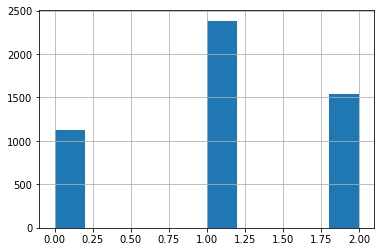

In [9]:
df_train[target].hist();

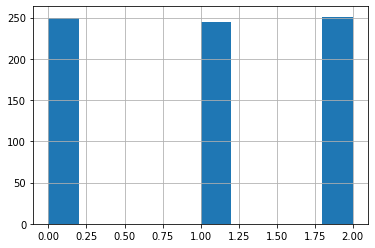

In [10]:
df_test[target].hist()

# Creating Dataset and DataLoader

In [11]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(TOKENIZER, do_lower_case = True)

In [12]:
sentence = df_train.loc[0, text]

print(sentence)
print(tokenizer.tokenize(sentence))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence)))

tirgoju saldējumu gadi tad biešu kaplēšana gadiem
['tir', '##go', '##ju', 'sal', '##dej', '##umu', 'ga', '##di', 'tad', 'bi', '##esu', 'kaple', '##sana', 'ga', '##diem']
[46756, 10797, 10761, 31119, 90062, 26117, 11887, 10703, 50586, 11342, 78448, 84178, 51308, 11887, 78711]


In [13]:
class Config:
    batch_size = 32
    max_len = 0

In [14]:
Config.max_len = 0

for sent in df_train.loc[:, text]:
    sent = tokenizer.encode(sent, add_special_tokens = True)
    Config.max_len = max(Config.max_len, len(sent))

Config.max_len

99

In [26]:
## TRAIN DATA

train_input_ids = torch.tensor([])
train_attention_masks = torch.tensor([])

for sent in df_train.loc[:, text]:
    encoded_sent = tokenizer.encode_plus(sent, add_special_tokens = True,
                                         max_length = Config.max_len, padding = 'max_length',
                                         return_tensors = 'pt')
    train_input_ids = torch.cat([train_input_ids, encoded_sent['input_ids']])
    train_attention_masks = torch.cat([train_attention_masks, encoded_sent['attention_mask']])

In [27]:
## TEST DATA

test_input_ids = torch.tensor([])
test_attention_masks = torch.tensor([])

for sent in df_test.loc[:, text]:
    encoded_sent = tokenizer.encode_plus(sent, add_special_tokens = True,
                                         max_length = Config.max_len, padding = 'max_length',
                                         return_tensors = 'pt')
    test_input_ids = torch.cat([test_input_ids, encoded_sent['input_ids']])
    test_attention_masks = torch.cat([test_attention_masks, encoded_sent['attention_mask']]) 

In [28]:
train_labels = torch.tensor(df_train[target])
test_labels = torch.tensor(df_test[target])
train_labels

tensor([1, 2, 2,  ..., 0, 2, 2])

In [29]:
from torch.utils.data import TensorDataset, random_split

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
val_size = int(0.3 * len(train_dataset))
train_size = len(train_dataset) - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [30]:
len(train_dataset), len(val_dataset), len(test_dataset)

(3542, 1517, 744)

In [32]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_loader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = Config.batch_size)
val_loader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = Config.batch_size)
test_loader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = Config.batch_size)

In [33]:
next(iter(val_loader))

[tensor([[  101., 29193., 30853.,  ...,     0.,     0.,     0.],
         [  101., 10321., 15190.,  ...,     0.,     0.,     0.],
         [  101., 39255., 30113.,  ...,     0.,     0.,     0.],
         ...,
         [  101., 13435., 10196.,  ...,     0.,     0.,     0.],
         [  101., 11284., 37583.,  ...,     0.,     0.,     0.],
         [  101., 99830., 10116.,  ...,     0.,     0.,     0.]]),
 tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 tensor([2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 2, 1, 2, 1, 2, 0, 0, 1,
         2, 2, 0, 0, 1, 0, 1, 1])]

In [37]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def train_model(model, train_loader, val_loader, optimizer, num_epochs, scheduler = None):
    train_loss_history = []
    train_f1_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        train_loss_accum = 0
        correct_samples = 0
        total_samples = 0

        tp, tn, fp, fn = 0, 0, 0, 0

        for index, (sentence, attention_mask, label) in enumerate(train_loader):
            model.zero_grad()

            sentence = sentence.to(device).long()
            attention_mask = attention_mask.to(device).long()
            label = label.to(device).long()

            output = model(sentence, token_type_ids = None, attention_mask = attention_mask, labels = label)
            loss_value, logits = output[0], output[1]
            train_loss_accum += loss_value.item()

            loss_value.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

            _, indices = torch.max(logits, 1)
            correct_samples += torch.sum(indices == label)
            tp += len(indices[(indices == label) & (indices == 1)])
            tn += len(indices[(indices == label) & (indices == 0)])
            fp += len(indices[(indices != label) & (indices == 1)])
            fn += len(indices[(indices != label) & (indices == 0)])
            total_samples += label.shape[0]
            
        avg_loss = train_loss_accum / index
        train_accuracy = float(correct_samples) / total_samples
        train_precision = tp / (tp + fp)
        train_recall = tp / (tp + fn)
        f1_train = (2*train_precision*train_recall) / (train_precision + train_recall)
        
        val_accuracy, f1_val = eval_model(model, val_loader)

        train_loss_history.append(avg_loss)
        train_accuracy_history.append(train_accuracy)
        train_f1_history.append(f1_train)
        val_accuracy_history.append(val_accuracy)
        val_f1_history.append(f1_val)

        print(f"EPOCH: {epoch}, Train_loss: {avg_loss}, Train_Acc: {train_accuracy}, Train_F1: {f1_train}, Val_Acc: {val_accuracy}, Val_F1: {f1_val}")
        if avg_loss < 0.05:
            return train_loss_history, train_accuracy_history, train_f1_history, val_accuracy_history, val_f1_history

    return train_loss_history, train_accuracy_history, train_f1_history, val_accuracy_history, val_f1_history

def eval_model(model, loader):

    model.eval() # Evaluation mode
    tp, tn, fp, fn = 0, 0, 0, 0
    correct_samples = 0
    total_samples = 0

    for sentence, attention_mask, label in loader:
        sentence = sentence.to(device).long()
        attention_mask = attention_mask.to(device).long()
        label = label.to(device).long()

        with torch.no_grad():
            preds = model(sentence, token_type_ids = None, attention_mask = attention_mask)
        
        _, indices = torch.max(preds[0], 1)
        correct_samples += torch.sum(indices == label)
        tp += len(indices[(indices == label) & (indices == 1)])
        tn += len(indices[(indices == label) & (indices == 0)])
        fp += len(indices[(indices != label) & (indices == 1)])
        fn += len(indices[(indices != label) & (indices == 0)])
        total_samples += label.shape[0]

    val_accuracy = float(correct_samples) / total_samples
    val_precision = tp / (tp + fp)
    val_recall = tp / (tp + fn)
    f1_val = (2*val_precision*val_recall) / (val_precision + val_recall)

    return val_accuracy, f1_val

In [50]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    MODEL_TYPE,
    num_labels = NUM_LABELS,
    output_attentions = False,
    output_hidden_states = False
)

model.to(device)

Some weights of the model checkpoint at FFZG-cleopatra/bert-emoji-latvian-twitter were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at FFZ

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [51]:
## TRAINING

from transformers import get_linear_schedule_with_warmup

EPOCHS = 5

optimizer = AdamW(model.parameters(), lr = 1e-5, eps = 1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = EPOCHS*len(train_dataset))

train_loss, train_accuracy, train_f1, val_accuracy, val_f1 = \
                    train_model(model, train_loader, val_loader, optimizer, EPOCHS, scheduler)

EPOCH: 0, Train_loss: 1.0487833245234055, Train_Acc: 0.466403162055336, Train_F1: 0.6419969345303262, Val_Acc: 0.5141727092946605, Val_F1: 0.6682107701215982
EPOCH: 1, Train_loss: 0.9472221314907074, Train_Acc: 0.5612648221343873, Train_F1: 0.7075316107751513, Val_Acc: 0.5781147000659196, Val_F1: 0.6285714285714286
EPOCH: 2, Train_loss: 0.8119157363067974, Train_Acc: 0.6408808582721626, Train_F1: 0.7409602845287493, Val_Acc: 0.6275543836519446, Val_F1: 0.6981470412432755
EPOCH: 3, Train_loss: 0.6952082406390797, Train_Acc: 0.7094861660079052, Train_F1: 0.7791519434628975, Val_Acc: 0.6321687541199736, Val_F1: 0.726010101010101
EPOCH: 4, Train_loss: 0.599349535595287, Train_Acc: 0.7648221343873518, Train_F1: 0.8198090692124104, Val_Acc: 0.6308503625576797, Val_F1: 0.7075283144570287


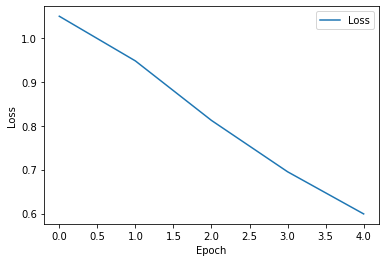

In [53]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = train_loss, label = 'Loss');
ax.set(xlabel = 'Epoch', ylabel = 'Loss');

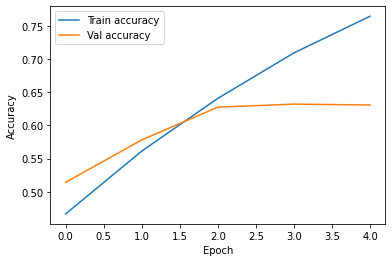

In [54]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = train_accuracy, label = 'Train accuracy');
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = val_accuracy, label = 'Val accuracy');
ax.set(xlabel = 'Epoch', ylabel = 'Accuracy');

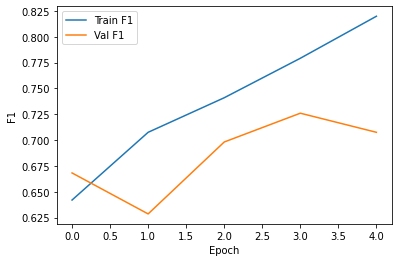

In [55]:
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = train_f1, label = 'Train F1');
ax = sns.lineplot(x = [i for i in range(EPOCHS)], y = val_f1, label = 'Val F1');
ax.set(xlabel = 'Epoch', ylabel = 'F1');

# Evaluation on test dataset

In [56]:
test_accuracy, test_f1 = eval_model(model, test_loader)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test F1: {test_f1}')

Test Accuracy: 0.6317204301075269
Test F1: 0.6328257191201353
